In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet

In [2]:
def plot_feature(alg,dtrain,top=25):
    feat_imp = pd.Series(alg.feature_importances_,index=dtrain.columns).sort_values(ascending=False)[0:top]
    feat_imp.plot(kind='bar', title='top {} Feature Importances'.format(top))
    plt.ylabel('Feature Importance Score')
    plt.show()

In [3]:
house=pd.read_csv("../data/data.csv")

In [4]:
# preprocess

In [5]:
# date
house['date']        =list(map(lambda strdate: datetime.strptime(strdate,'%Y%m%dT%H%M%S'), house['date']))
house['sale_year']   =list(map(lambda date: date.year, house['date']))
house['sale_month']  =list(map(lambda date: date.month,house['date']))
house['sale_weekday']=list(map(lambda date: date.dayofweek,house['date'] ))
# location 
house['zipcode']=house['zipcode'].astype('category')
del house['id'] 
house['log_price']=np.log(house['price']) # log_normal distribution plot

In [6]:
# Train Test Split 

In [7]:
X_data = house.drop(columns=['price','log_price','date'])
y_data = house['log_price']
X_train, X_test, y_train, y_test=train_test_split(X_data,y_data,test_size=0.33, random_state=42)

# BaseLine Model 
### 1. untuned tree-based model (random forest)

In [8]:
rf_model=RandomForestRegressor()
rf_model.fit(X_train,y_train)
y_pred=rf_model.predict(X_test)
mean_squared_error(y_test,y_pred) # untuned random forest results

0.03522559117307039

### 2. tunned linear model - Elastic Net

** objective function**  :  $ \frac{1}{2n} ||y - \beta X||^2_2 + \alpha* ratio * ||\beta||_1  + 0.5 * \alpha * (1 - ratio) * ||\beta||^2_2  $

$$ x * L1 + y * L2 $$ 
$$\alpha = x + y \space and \space ratio = \frac{x}{  (x + y)} $$

**alpha** control the total penalty for l2 and l1  
**ratio** control the weight between l1 and l2

In [9]:
elastic_model = ElasticNet()

In [10]:
param_test1 = {
     "alpha":[0.01,0.1,0.2],
    'l1_ratio':[0.0,0.5,1],
    'fit_intercept': [True,False],
    'normalize':[True,False]
}
gsearch1 = GridSearchCV(estimator = elastic_model, 
param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose=0)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

C:\Wesley_Tao\6.Software\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


({'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.0, 'normalize': False},
 -0.06781044351344419)

In [11]:
elastic_model.set_params(**gsearch1.best_params_)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [12]:
elastic_model.fit(X_train,y_train)
y_pred=elastic_model.predict(X_test)
mean_squared_error(y_test,y_pred)

C:\Wesley_Tao\6.Software\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.06947561889100491

# light GBM

** objective function**  is L2 loss

**Input**: I: training data, d: iterations  
**Input**: a: sampling ratio of large gradient data  
**Input**: b: sampling ratio of small gradient data  
**Input**: loss: loss function, L: weak learner  
models ← {}, fact ← (1−a)/b  
topN ← a × len(I) , randN ← b × len(I)  
**for i = 1 to d do **  
&ensp; preds ← models.predict(I)  
&ensp; g ← loss(I, preds), w ← {1,1,...}  
&ensp;  sorted ← GetSortedIndices(abs(g))  
&ensp; topSet ← sorted[1:topN]  
&ensp; randSet ← RandomPick(sorted[topN:len(I)],randN)  
&ensp; usedSet ← topSet + randSet  
&ensp; w[randSet] × = fact . Assign weight f act to the small gradient data.  
&ensp; newModel ← L(I[usedSet], − g[usedSet],w[usedSet])  
&ensp; models.append(newModel)

LightGBM offers good accuracy with integer-encoded categorical features.   
LightGBM applies Fisher (1958) to find the optimal split over categories as described here. This often performs better than **one-hot encoding**.  

**Categorical features** must be encoded as non-negative integers (int) less than Int32.MaxValue (2147483647). It is best to use a **contiguous range of integers**.  
Use categorical_feature to specify the categorical features. Refer to the parameter categorical_feature in Parameters. 

Use **min_data_per_group, cat_smooth** to deal with over-fitting (when #data is small or #category is large).  

For a categorical feature with high cardinality (#category is large), it often works best to treat the feature as numeric, either by simply ignoring the categorical interpretation of the integers or by embedding the categories in a low-dimensional numeric space.  

In [13]:
lgb_model=LGBMRegressor()
lgbm_params = {
    "n_estimators":3000,
    "boosting_type":"gbdt",
#     "application":"conitunous",
    "learning_rate":0.1, 
    "min_data_in_leaf":80, # dealt with overfiting
    "num_leaves":50,
#     "min_data_per_group":[10,30,50],
#     "cat_smooth":[0,0.5,1],
    "max_depth":-1,
#     "scale_pos_weight":2,
#     "drop_rate":0.02,
    "bagging_freq":1,
    "bagging_fraction":0.8,
    "metric":"rmse",
    "min_split_gain":0.0,
#     "colsample_bytree":0.0
    "save_binary":True,
    "max_bin":100
}
lgb_model.set_params(**lgbm_params) #base model

LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, learning_rate=0.1,
       max_bin=100, max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=80, min_split_gain=0.0,
       n_estimators=3000, n_jobs=-1, num_leaves=50, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, save_binary=True,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [14]:
lgbm_train = lgb.Dataset(data=X_train,
                          label=y_train,
#                           categorical_feature=cat_col,
                          free_raw_data=False)

In [15]:
cv_results = lgb.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     num_boost_round=1000,
                     early_stopping_rounds=200,
                     stratified=False,
#                      objective="regression",
                     verbose_eval=50,
                     metrics=['mse'])

C:\Wesley_Tao\6.Software\Anaconda\lib\site-packages\lightgbm\engine.py:394: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	cv_agg's l2: 0.0315795 + 0.0017749
[100]	cv_agg's l2: 0.0304633 + 0.00177822
[150]	cv_agg's l2: 0.0304682 + 0.00178045
[200]	cv_agg's l2: 0.030597 + 0.00178114
[250]	cv_agg's l2: 0.0307724 + 0.00169357
[300]	cv_agg's l2: 0.0309726 + 0.00173147


In [16]:
optimum_boost_rounds = np.argmin(cv_results['l2-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best LGBM CV result = {}'.format(np.min(cv_results['l2-mean']))) #cv_agg's mape: 0.0418631 + 0.000355628

Optimum boost rounds = 122
Best LGBM CV result = 0.03038865614705775


# parameter tuning
**max num_leaves**  This is the main parameter to control the complexity of the tree model.   
Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. 

**min_data_in_leaf** This is a very important parameter to prevent over-fitting in a leaf-wise tree.   
Its optimal value depends on the number of training samples and num_leaves.   
Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.   
In practice, setting it to hundreds or thousands is enough for a large dataset.

**max_depth. ** You also can use max_depth to limit the tree depth explicitly.

In [17]:
lgb_model.set_params(n_estimators=122)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, learning_rate=0.1,
       max_bin=100, max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=80, min_split_gain=0.0,
       n_estimators=122, n_jobs=-1, num_leaves=50, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, save_binary=True,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [18]:
param_test1 = {
     "num_leaves":[10,30,50],
    "cat_smooth":[0,0.5,1],
    'min_data_in_leaf':list(range(1,100,20)) 
}
gsearch1 = GridSearchCV(estimator = lgb_model, 
param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose=-1)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 225 out of 225 | elapsed:  1.8min finished


({'cat_smooth': 0, 'min_data_in_leaf': 41, 'num_leaves': 50},
 -0.026281361987260575)

In [19]:
lgb_model.set_params(**gsearch1.best_params_)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
       cat_smooth=0, class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_bin=100, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=41,
       min_split_gain=0.0, n_estimators=122, n_jobs=-1, num_leaves=50,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       save_binary=True, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [20]:
lgb_model.fit(X_train,y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
       cat_smooth=0, class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_bin=100, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=41,
       min_split_gain=0.0, n_estimators=122, n_jobs=-1, num_leaves=50,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       save_binary=True, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [21]:
y_pred=lgb_model.predict(X_test)
mean_squared_error(y_test,y_pred) # untuned random forest results

0.026607985573588906

In [22]:
## feature importance 

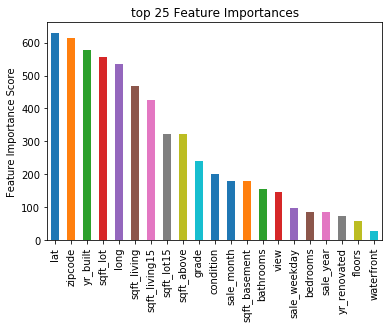

In [23]:
plot_feature(lgb_model,dtrain=X_train)

In [24]:
# important features
# 1. Location (zip code latitude and longituted)
# 2. square foot
# 3. grade & condition 
# 4. Seasonality (seasonl sale)
# 5. floor plan (eg 2b3b 2 floor)
# 6. renovation
# 7. view
# 8. waterfront